### Patrick Horlaville (260931235) - Problem Set 2 - PHYS 641 : Observational Techniques in Modern Astrophysics

Prof: Jon Sievers. TA: Anan Lu

In [208]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

## Problem 1

First we load our data from the .fits file and look at the total map:

In [12]:
hdul = fits.open('advact_tt_patch.fits')
act_map = hdul[0].data
hdul.close()

act_map = np.asarray(act_map, dtype = 'float')

In [25]:
np.shape(act_map)

(4000, 6000)

Text(0.5, 1.0, 'Full map')

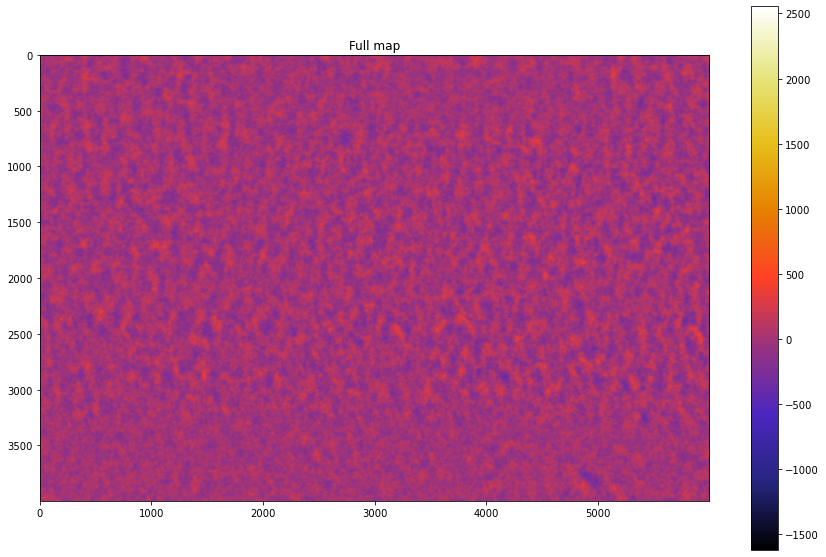

In [207]:
plt.figure(figsize = (15, 10))
plt.imshow(act_map, cmap = 'CMRmap')
plt.colorbar()
plt.title('Full map')

So our map has a shape of 6000 by 4000 pixels

We are interested into fitting a Gaussian to the center of the map, where there is the cluster. Let's look more closely at how it looks. We flesh out a 100 by 100 pixel map around the center:

In [55]:
xc = 3000
yc = 2000
wid = 50

act_center = act_map[yc - wid: yc + wid, xc - wid: xc + wid]

Text(0.5, 1.0, 'Map zoomed on cluster')

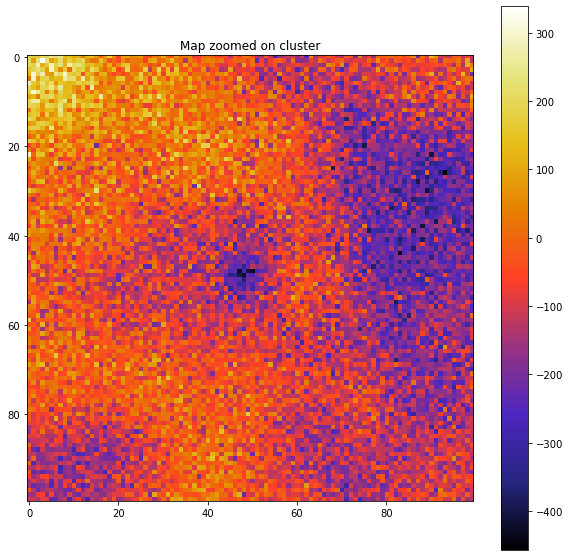

In [56]:
plt.figure(figsize = (10, 10))
plt.imshow(act_center, cmap = 'CMRmap')
plt.colorbar()
plt.title('Map zoomed on cluster')

Now, we would like to fit a Gaussian on this cluster. To do so, we can use Jon's snippets from lecture 2, which also aimed at fitting a Gaussian over a similar map, so the re-usability here is pretty convenient. To the Gaussian model, we add an additive parameter to the whole function destined to account for the background noise. The spread is overestimated otherwise and the fit is really not that good.

In [195]:
def mygauss(pars, width):
    vec = np.asarray(np.arange(- width, width), dtype='float')
    amp = pars[0]
    dx = pars[1]
    dy = pars[2]
    sig = pars[3]
    k = pars[4]

    xvec = vec - dx
    yvec = vec - dy
    xmat = np.outer(xvec,np.ones(len(xvec)))
    ymat = np.outer(np.ones(len(yvec)),yvec)
    rmat = xmat**2 + ymat**2
    model = np.exp(-0.5*(rmat/sig**2))*amp + k

    return model

def get_model_derivs(fun,pars,dpar,width):
    model=fun(pars,width)
    npar=len(pars)
    derivs=[None]*npar
    for i in range(npar):
        pp=pars.copy()
        pp[i]=pars[i]+dpar[i]
        m_plus=fun(pp,width)
        pp[i]=pars[i]-dpar[i]
        m_minus=fun(pp,width)
        derivs[i]=(m_plus-m_minus)/(2*dpar[i])
    return model, derivs

def get_model_derivs_ravel(fun,pars,dpar,width):
    model,derivs=get_model_derivs(fun,pars,dpar,width)
    model=np.ravel(model)
    npar=len(pars)
    derivs_out=np.empty([len(model),len(pars)])
    for i in range(npar):
        derivs_out[:,i]=np.ravel(derivs[i])
    return model, derivs_out

def newton(pars,data,fun,width,dpar,niter=10):
    for i in range(niter):
        model, derivs = get_model_derivs_ravel(fun, pars, dpar, width)
        resid = data - model
        lhs = derivs.T@derivs
        rhs = derivs.T@resid
        shift = np.linalg.pinv(lhs)@rhs
        pars = pars + shift
    return pars

We use the newton() function to make the fit and get our parameters

First, we need to find approximate initial values for our parameters. Well, the amplitude seems to be of order ~ -350, the peak should be at the center, the spread seems to be of order a few pixels, and the background noise is slightly above 0 it seems. So we can set our array of initial parameters. Similarly, given the order of our parameters, we can set the array of increments to be taken for each parameter's refinement:

In [196]:
p0 = np.array([-350, 0, 0, 5, 5]) # amplitude, x-shift, y-shift, spread, background noise level
dp = np.array([1, 0.01, 0.01, 0.1, 1])

In [197]:
params = newton(p0, np.ravel(act_center), mygauss, wid, dp, niter = 100)

In [198]:
newt_model = mygauss(params, wid)

Text(0.5, 1.0, 'Map zoomed on cluster, with the peak removed')

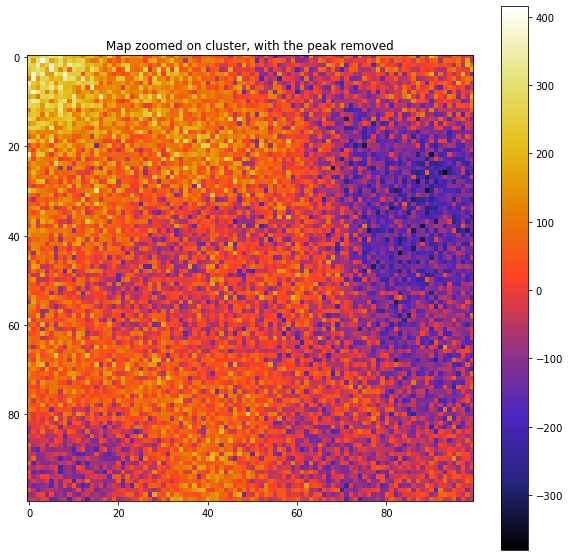

In [199]:
plt.figure(figsize = (10, 10))
plt.imshow(act_center - newt_model, cmap = 'CMRmap')
plt.colorbar()
plt.title('Map zoomed on cluster, with the peak removed')

The fit seems to have a done a fair enough job! The peak has clearly vanished. We have the following values for our parameters:

In [171]:
print('Amplitude:', params[0])
print('Peak position: (', params[1], ', ', params[2], ') relative to the center of the map')
print('Spread (sigma):', params[3])
print('Background noise:', params[4])

Amplitude: -187.87694029486894
Peak position: ( -1.41740747766862 ,  -2.6834509727211335 ) relative to the center of the map
Spread (sigma): 4.996425800981493
Background noise: -76.56625363401962


## Problem 2

Now we would like to take the power spectrum of our map. To do so we will smooth the absolute value of the squared 2D FFT by convolving the squared FFT with a Gaussian.

We will make use of the function get_gauss_kernel from the act_mf_tools file:

In [174]:
from act_mf_tools import *

In [176]:
def estimate_ps(vect, sig):    

    kernel = get_gauss_kernel(vect, sig, norm = True)
    
    kernel_ft = np.fft.fft2(kernel)
    
    PS = np.abs(np.fft.fft2(vect))**2
    
    PS_FT = np.fft.fft2(PS)
    
    smooth_PS = np.fft.ifft2(kernel_ft*PS_FT)
    
    return np.real(smooth_PS)

In [177]:
smoothed_PS = estimate_ps(act_map, params[3])

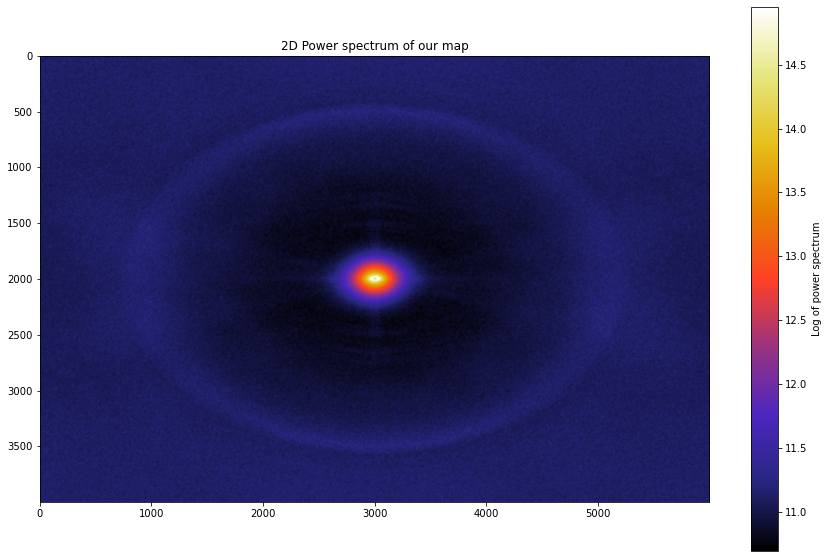

In [185]:
plt.figure(figsize=(15, 10))

plt.title('2D Power spectrum of our map')
plt.imshow(np.fft.fftshift((np.log10(smoothed_PS))), cmap = 'CMRmap')
plt.colorbar(label = 'Log of power spectrum')

## Problem 3

Now we want to apply N^-1 to the map. The routine has to accept a non-padded map, and it must return a non-padded map

In [216]:
def filter_map(vec, smoothed_ps):
     
    stack_vec = np.hstack([vec, np.fliplr(vec)])
    pad_vec = np.vstack([stack_vec, np.flipud(stack_vec)])
    
    stack_ps = np.hstack([smoothed_ps, np.fliplr(smoothed_ps)])
    pad_ps = np.vstack([stack_ps, np.flipud(stack_ps)])
    
    map_fft = np.fft.fft2(pad_vec)
    N1 = 1/pad_ps
    
    pad_filter_map = np.real(np.fft.ifft2(map_fft*N1))
    
    nrows = pad_filter_map.shape[0]//2
    ncols = pad_filter_map.shape[1]//2
    
    unpad_filter_map = pad_filter_map[0:nrows, 0:ncols] * vec.size

    return unpad_filter_map

In [204]:
act_filtered_map = filter_map(act_map, smoothed_PS)

In [205]:
act_center_filtered_map = act_filtered_map[yc - wid: yc + wid, xc - wid: xc + wid]

Text(0.5, 1.0, 'Filtered Map')

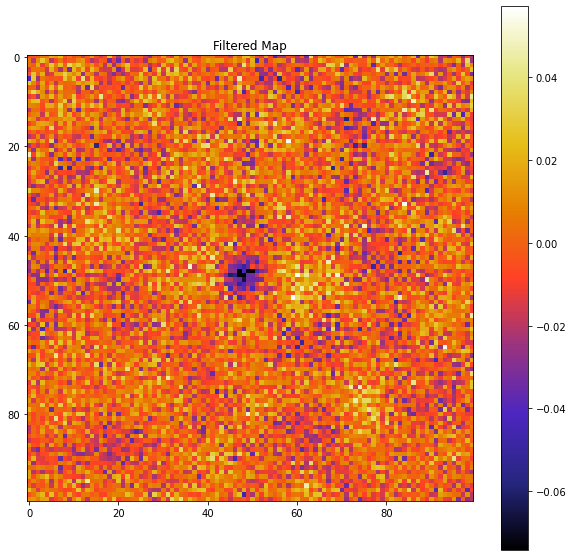

In [206]:
plt.figure(figsize = (10, 10))
plt.imshow(act_center_filtered_map, cmap = 'CMRmap')
plt.colorbar()
plt.title('Filtered Map')

## Problem 4

First, start with some white noise map:

In [226]:
white = np.random.normal(loc = 0, scale = 5, size = (500, 500))

From which we take the power spectrum:

In [230]:
ps_white = estimate_ps(white, 5)

Then filter the power spectrum map:

In [231]:
white_filter = filter_map(white, ps_white)

What do we expect the variance to be on this filtered power spectrum from a white noise map? Well, the std of our white noise map was set to 5, so its variance is 25. The variance of its power spectrum is the variance of the map squared, hence we expect the variance of the power spectrum to be (25^2) = 625. Finally, the filtered power spectrum takes the FT of the white noise map divided by its power spectrum, which should result in a variance equal to the ratio of the two variances, that is 25/625 = 0.04. Let's check:

In [233]:
np.var(white_filter)

0.040389109761664446

Indeed, the variance of the filtered power spectrum is ~ 0.04 !

## Problem 5

Here we make our matched filter map for the center of the map. To do so we use our signal of the map, our Gaussian model and our noise model. The method, as prescribed in class, goes as follows:

In [279]:
gauss_model_cent = get_gauss_kernel(act_center, params[3])
noise_model = estimate_ps(act_center, sig = 5)

In [280]:
signal_ft = np.fft.fft2(act_center)
model_ft = np.fft.fft2(gauss_model_cent)
    
Ninv_model = model_ft / noise_model
    
mf_rhs = np.real(np.fft.ifft2(Ninv_model*np.conj(signal_ft)))*act_center.size
mf_rhs_check = np.real(np.fft.ifft2(np.conj(signal_ft/noise_model)*model_ft))*act_center.size
    
lhs = np.real(np.fft.ifft2(Ninv_model))*act_center.size

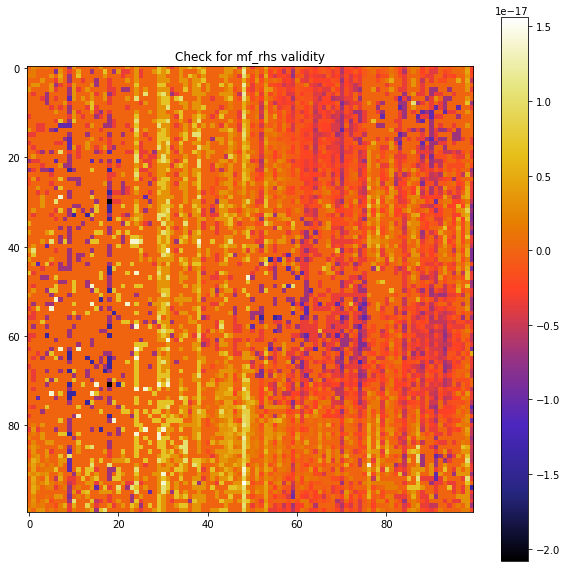

In [283]:
plt.figure(figsize = (10, 10))
plt.imshow(mf_rhs - mf_rhs_check, cmap = 'CMRmap')
plt.title('Check for mf_rhs validity')
plt.colorbar()

Given the order of magnitude of the difference between mf_rhs and mf_rhs_check is of about 1e-17 and that difference seems to be uniform, this is a good sign for the accuracy of our matched filter map. Now we can plot the matched filter map:

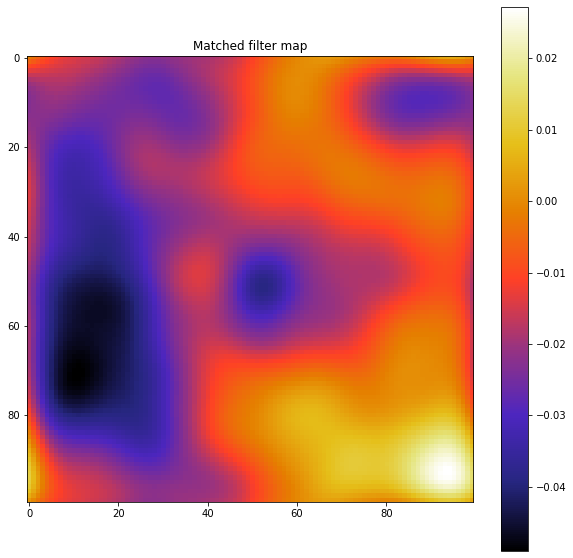

In [285]:
plt.figure(figsize = (10, 10))
plt.imshow(mf_rhs, cmap = 'CMRmap')
plt.title('Matched filter map')
plt.colorbar()

Our map above is normalized. To retrieve the amplitudes, un-normalize through the left hand side term.

In [298]:
amp = mf_rhs / np.sum(lhs)

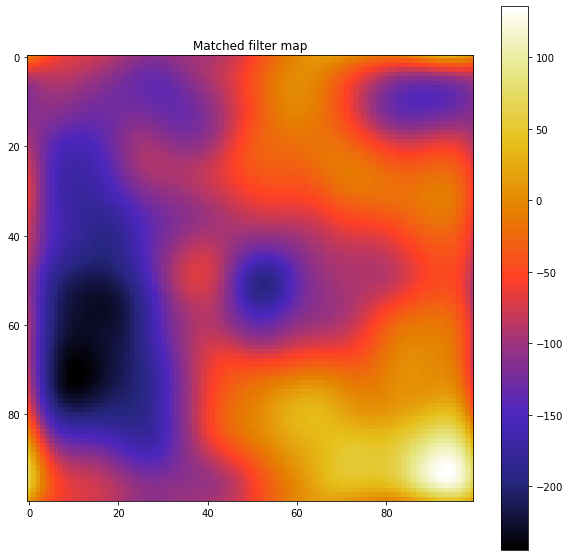

In [299]:
plt.figure(figsize = (10, 10))
plt.imshow(amp, cmap = 'CMRmap')
plt.title('Matched filter map')
plt.colorbar()

It's odd that this very low region, stronger than the peak, appears on the left of the peak.

We can find the different features of this map:

In [301]:
print('Peak amplitude:', amp[0:25, 0:25].min())
print('Error on the amplitude of the map:', 1 / np.sqrt(np.sum(lhs)))
print('Error on the amplitude of the peak:', np.std(amp[0:25, 0:25]))

Peak amplitude: -165.9774470511253
Error on the amplitude of the map: 70.68691845693503
Error on the amplitude of the peak: 24.63792699443972


The uncertainty on the amplitude of the peak is reasonable compared to its value, however again, this lower left region is making me doubt of the accuracy of the process I implemented.

## Problem 6

Now we can do the same for a bigger chunk of the map and try to discover a new cluster...

In [303]:
wid_b = 300

act_big = act_map[yc - wid_b: yc + wid_b, xc - wid_b: xc + wid_b]

In [304]:
gauss_model_b = get_gauss_kernel(act_big, params[3])
noise_model_b = estimate_ps(act_big, sig = 5)

In [305]:
signal_ft_b = np.fft.fft2(act_big)
model_ft_b = np.fft.fft2(gauss_model_b)
    
Ninv_model_b = model_ft_b / noise_model_b
    
mf_rhs_b = np.real(np.fft.ifft2(Ninv_model_b*np.conj(signal_ft_b)))*act_big.size
mf_rhs_check_b = np.real(np.fft.ifft2(np.conj(signal_ft_b/noise_model_b)*model_ft_b))*act_big.size
    
lhs_b = np.real(np.fft.ifft2(Ninv_model_b))*act_big.size

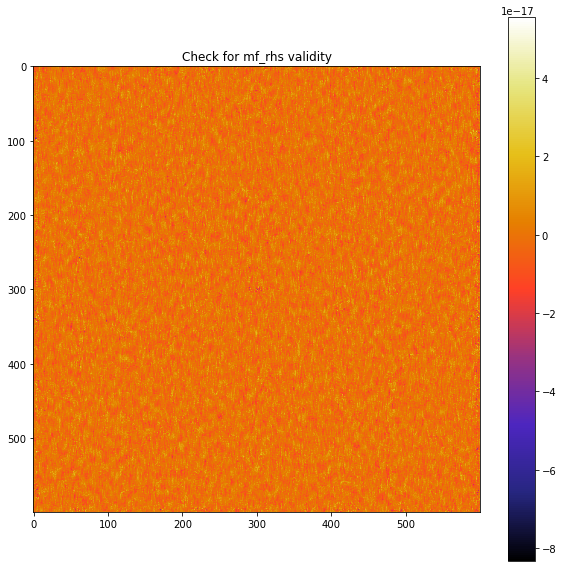

In [306]:
plt.figure(figsize = (10, 10))
plt.imshow(mf_rhs_b - mf_rhs_check_b, cmap = 'CMRmap')
plt.title('Check for mf_rhs validity')
plt.colorbar()

Again, the check seems alright, with a difference of order 1e-17.

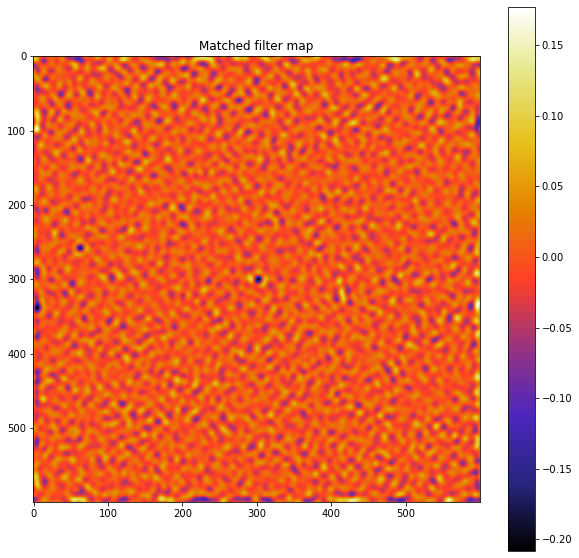

In [307]:
plt.figure(figsize = (10, 10))
plt.imshow(mf_rhs_b, cmap = 'CMRmap')
plt.title('Matched filter map')
plt.colorbar()

A new shadow has appeared! about 50 pixels up, 230 pixels to the left. So the RA changed by about 2 degrees and the DEC by about 0.4 degrees. Given the coordinates (RA, DEC) = (10.851, -20.6214) degrees of A2813, we can estimate the coordinates of this mystery object to be ~(8.8, -20.2) degrees

That could correspond to the object ACT-CL J0035.4-2015, whose coordinates are fairly close to those of that myestery object according to the NED.